# Clustering particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "3n_3m_0f_230522_1"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [80, 1840]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 108311
Frames resolution: 1080 x 1920


In [4]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [5]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,1474.065398,4.580262,1473.958171,4.599179,0.0,1425.000000,2.000000,0.513725,1425.000000,0.000000,1.567228,841.0,100.163951,15.752113,0.987557,7
1,1,0,80.963613,660.129269,82.713296,664.418204,NaN,80.963613,660.129269,NaN,80.963613,660.129269,0.376469,6266.0,185.368949,78.190270,0.906685,7
2,2,0,245.672559,705.787974,246.479345,702.985652,NaN,245.672559,705.787974,NaN,245.672559,705.787974,0.738464,8881.0,220.456627,92.581731,0.907545,7
3,3,0,128.580205,967.699039,137.312847,974.609538,NaN,128.580205,967.699039,NaN,128.580205,967.699039,1.051289,12387.0,270.782792,82.682335,0.952242,7
4,4,0,1696.271722,1029.411532,1696.161719,1029.409823,0.0,1691.000000,1009.000000,0.423529,1687.000000,1042.000000,1.405618,1266.0,116.175602,30.266881,0.965467,7
5,5,0,1280.510551,1057.093423,1278.913108,1057.227712,0.0,1331.000000,1037.000000,0.545098,1292.000000,1068.000000,-1.556426,4881.0,223.509966,50.306980,0.974341,7


In [6]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
print("Initial tracking at time 0:\n", tracking_0[cols])

if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([1, 2, 3])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        -tracking_0["orientation"].values[0],
        -tracking_0["orientation"].values[1],
        -tracking_0["orientation"].values[2]
    ])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

Initial tracking at time 0:
    id  time  id_count   position_x   position_y  orientation
0   0     0         7  1474.065398     4.580262     1.567228
1   1     0         7    80.963613   660.129269     0.376469
2   2     0         7   245.672559   705.787974     0.738464
3   3     0         7   128.580205   967.699039     1.051289
4   4     0         7  1696.271722  1029.411532     1.405618
5   5     0         7  1280.510551  1057.093423    -1.556426
6   6     0         7   509.566146  1070.119792     1.543133


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
1,0,0,80.963613,660.129269,82.713296,664.418204,NaN,80.963613,660.129269,NaN,80.963613,660.129269,-0.376469,6266.0,185.368949,78.190270,0.906685,7
2,1,0,245.672559,705.787974,246.479345,702.985652,NaN,245.672559,705.787974,NaN,245.672559,705.787974,-0.738464,8881.0,220.456627,92.581731,0.907545,7
3,2,0,128.580205,967.699039,137.312847,974.609538,NaN,128.580205,967.699039,NaN,128.580205,967.699039,-1.051289,12387.0,270.782792,82.682335,0.952242,7
7,0,3,81.724377,660.963797,83.782480,666.012395,NaN,81.724377,660.963797,NaN,81.724377,660.963797,0.365962,6215.0,183.600916,79.858683,0.900451,7
8,1,3,236.476161,644.928484,236.390187,645.756002,NaN,236.476161,644.928484,NaN,236.476161,644.928484,0.739960,1636.0,110.731355,29.629032,0.963537,7
9,2,3,248.207723,720.212091,249.963700,719.961821,NaN,248.207723,720.212091,NaN,248.207723,720.212091,0.914566,7096.0,213.556619,60.727125,0.958717,7
10,3,3,128.541468,967.675119,137.273426,974.554754,NaN,128.541468,967.675119,NaN,128.541468,967.675119,1.051814,12383.0,270.697061,82.586990,0.952323,7


In [7]:
df_tracked.sort_values(["time", "id"]).tail(5)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
37277,0,108309,1013.734269,787.678538,1013.807499,787.005868,0.0,913.000000,695.000000,0.588235,917.000000,703.000000,0.942878,11681.0,283.031256,83.182840,0.955836,5
37278,1,108309,79.649016,835.024143,80.346741,833.391778,0.0,82.000000,767.000000,0.419608,80.000000,802.000000,-0.188365,4929.0,127.877365,52.908117,0.910395,5
37279,2,108309,500.563284,897.409871,508.149833,897.286384,NaN,500.563284,897.409871,NaN,500.563284,897.409871,-1.499720,10840.0,307.876578,84.463184,0.961632,5
37280,3,108309,1280.333551,1056.440895,1278.966261,1056.530560,0.0,1326.000000,1035.000000,0.537255,1330.000000,1057.000000,-1.557139,4602.0,209.657998,53.536424,0.966848,5
37281,4,108309,493.765980,1068.754424,494.511877,1068.754548,0.0,448.000000,1056.000000,0.584314,549.000000,1064.000000,1.548164,2769.0,153.962047,24.627626,0.987124,5


## Velocities distribution in each frame

In [8]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


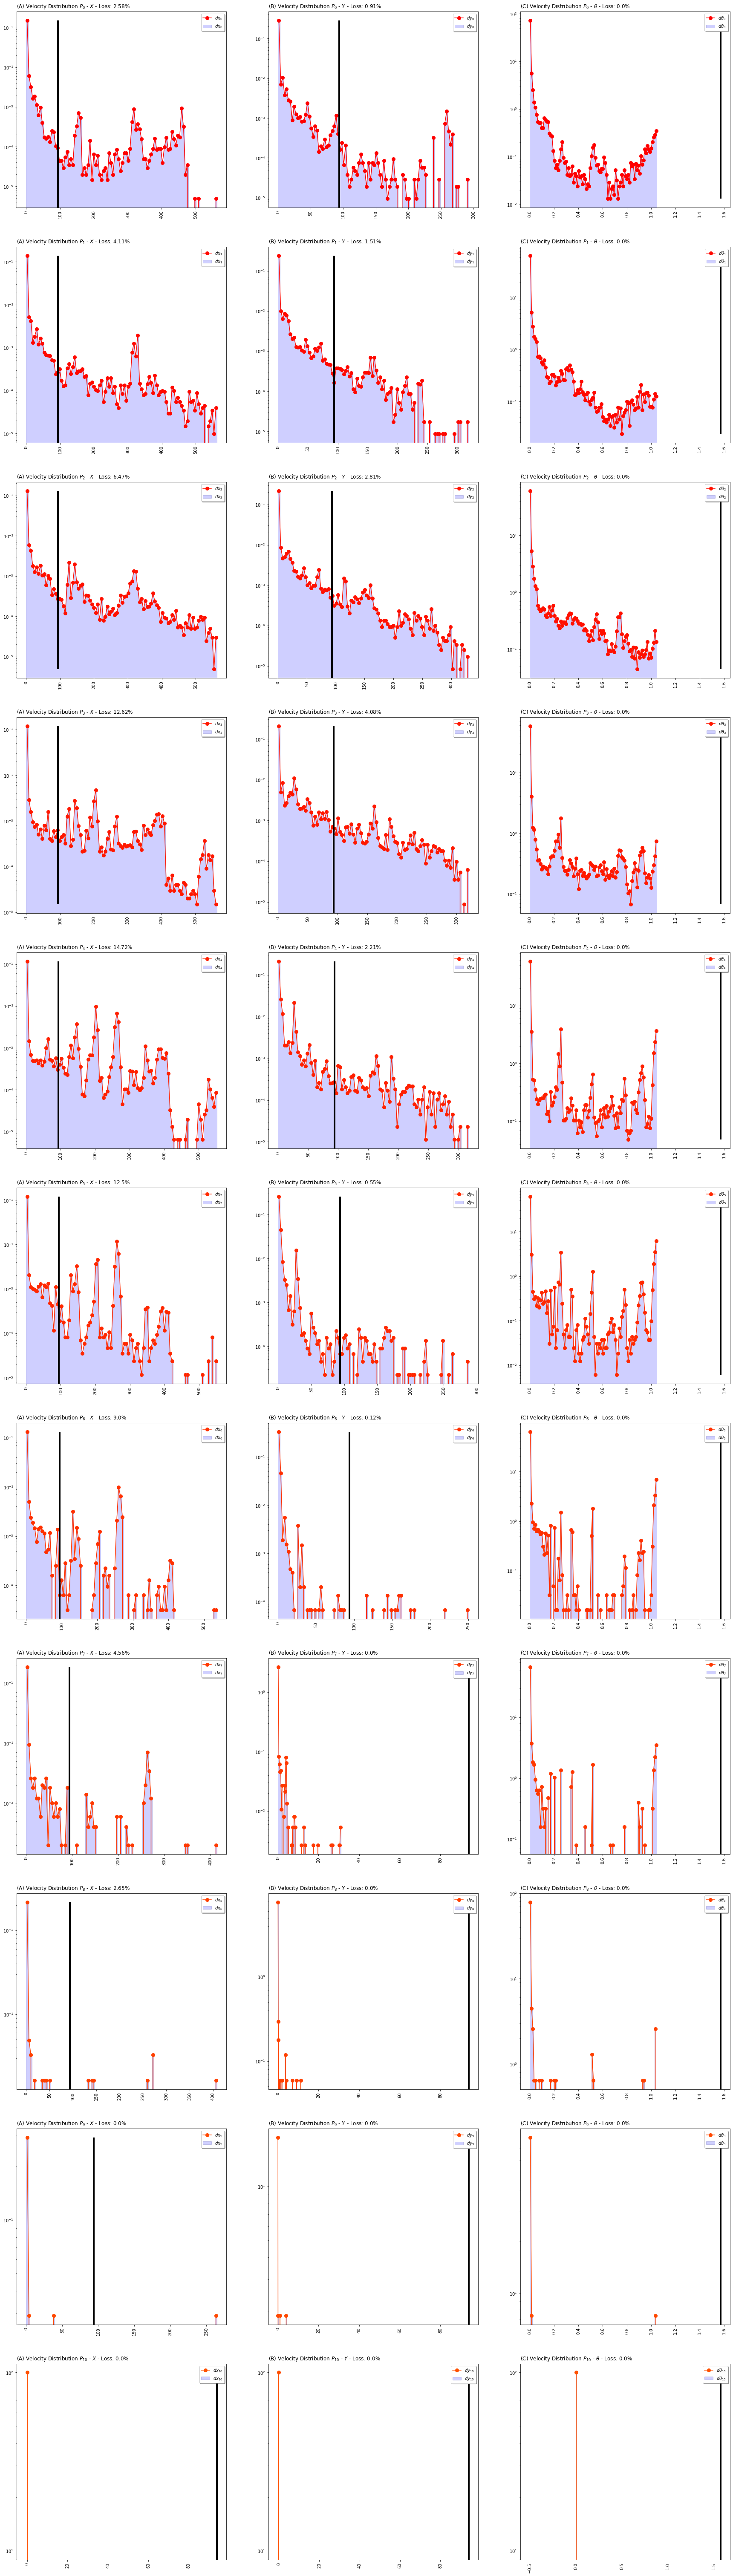

In [9]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [10]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,2,10
1,3,2193
2,4,30780
3,5,61095
4,6,57402
5,7,32770
6,8,8432
7,9,1233
8,10,120
9,11,22


## Clustering frames

In [11]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 56.947158782993164 



In [12]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [13]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,2,False,False,False,0.003092
1,2,True,True,False,0.002061
2,3,False,False,False,1.011558
3,3,False,True,False,0.025250
4,3,True,False,False,0.027827
5,3,True,True,False,0.065445
6,4,False,False,False,14.627661
7,4,False,True,False,0.242712
8,4,True,False,False,0.633319
9,4,True,True,False,0.357627


In [14]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 52.99998686093977 
	- Angle: 56.947158782993164 



In [15]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 29.28239740396477%
Final loss data X-axis: 5.588861563121214%
Final loss data Y-axis: 0.4800779439149531%
Final loss data Angle : 1.437090931948362%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,3,False,False,False,0.002357
1,3,False,False,True,0.075430
2,3,False,True,False,0.002357
3,3,False,True,True,0.051072
4,3,True,False,True,0.036143
5,3,True,True,False,0.169717
6,3,True,True,True,70.380527
7,4,False,False,False,0.002357
8,4,False,False,True,0.017286
9,4,False,True,True,0.066787


In [16]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 52.99998686093977 
	- Angle: 56.947158782993164 



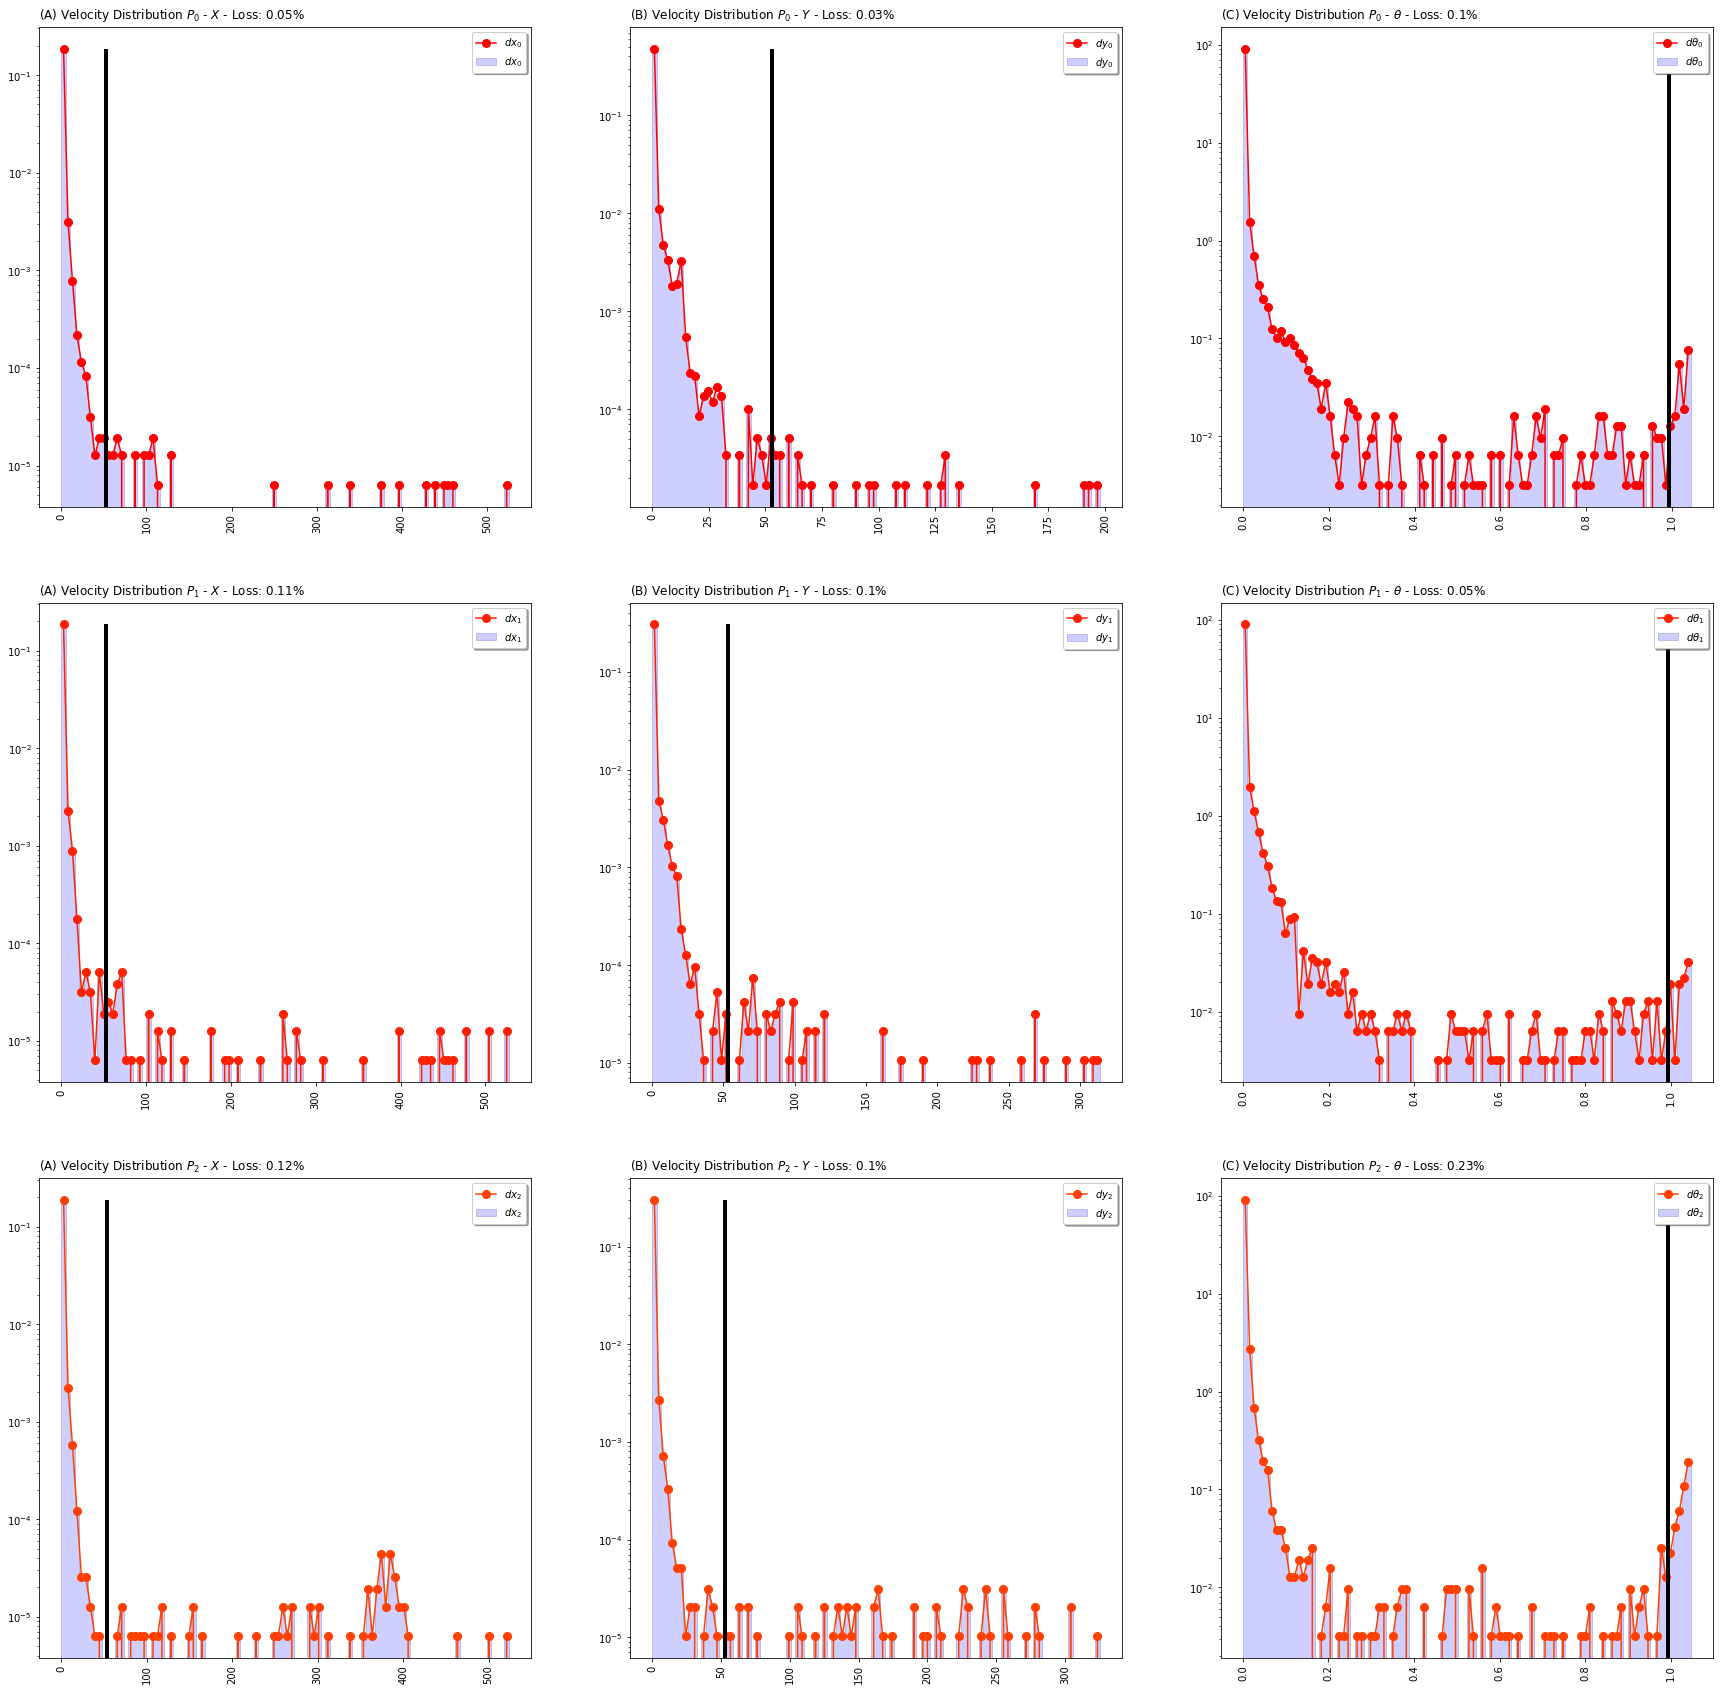

In [17]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [18]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [19]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,80.963613,660.129269,82.713296,664.418204,NaN,80.963613,660.129269,NaN,80.963613,660.129269,-0.376469,6266.0,185.368949,78.190270,0.906685,3,NaN,NaN,NaN,NaN,False,False,False
732,1,0,245.672559,705.787974,246.479345,702.985652,NaN,245.672559,705.787974,NaN,245.672559,705.787974,-0.738464,8881.0,220.456627,92.581731,0.907545,3,NaN,NaN,NaN,NaN,False,False,False
1464,2,0,128.580205,967.699039,137.312847,974.609538,NaN,128.580205,967.699039,NaN,128.580205,967.699039,-1.051289,12387.0,270.782792,82.682335,0.952242,3,NaN,NaN,NaN,NaN,False,False,False
2196,0,3,81.343995,660.546533,83.247888,665.215300,NaN,81.343995,660.546533,NaN,81.343995,660.546533,-0.376469,6266.0,185.368949,78.190270,0.906685,3,3.0,0.126794,0.139088,0.0,False,False,False
2197,1,3,245.672559,705.787974,246.479345,702.985652,NaN,245.672559,705.787974,NaN,245.672559,705.787974,-0.738464,8881.0,220.456627,92.581731,0.907545,3,3.0,0.000000,0.000000,0.0,False,False,False
2198,2,3,128.560837,967.687079,137.293137,974.582146,NaN,128.560837,967.687079,NaN,128.560837,967.687079,-1.051289,12387.0,270.782792,82.682335,0.952242,3,3.0,-0.006456,-0.003987,0.0,False,False,False
2199,0,6,81.333298,660.521966,83.297353,665.357750,NaN,81.333298,660.521966,NaN,81.333298,660.521966,-0.376469,6266.0,185.368949,78.190270,0.906685,3,3.0,-0.003566,-0.008189,0.0,False,False,False
2200,1,6,245.672559,705.787974,246.479345,702.985652,NaN,245.672559,705.787974,NaN,245.672559,705.787974,-0.738464,8881.0,220.456627,92.581731,0.907545,3,3.0,0.000000,0.000000,0.0,False,False,False
2201,2,6,128.317740,967.726088,136.918579,974.593895,NaN,128.317740,967.726088,NaN,128.317740,967.726088,-1.051289,12387.0,270.782792,82.682335,0.952242,3,3.0,-0.081032,0.013003,0.0,False,False,False


## Visualize final data

In [20]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  2.21it/s]


In [21]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/3n_3m_0f_230522_1_c.zip'